# incremental_PMU_placement_2000-bus

* Code is written by Shiva on February, 9, 2023

### The objective of this code is to train DNN-SE with different PMU placement strategies to lower the estimation errors in all the buses in 2000-bus down to a certain value. (1% for MAPE, 0.6 degrees for MAE)
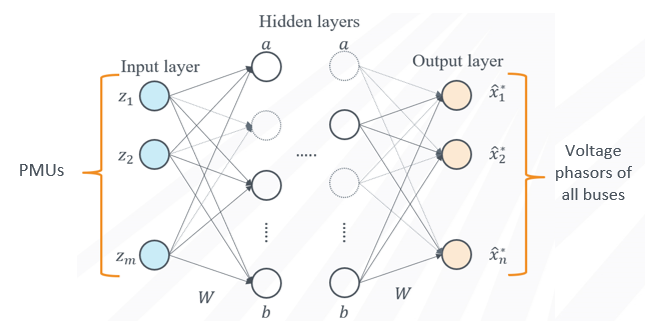

### 1. Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
from scipy import stats
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import gradients
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras import regularizers
from sklearn.utils import shuffle
from tensorflow.keras import losses
import h5py
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from time import time
np.random.seed(250)
tf.random.set_seed(250)

### 2. Import system configuration

In [2]:
#Import the branch information of the 2000-bus system (the connectivity between buses)
branch_inf= pd.read_csv('From_To_branch_indices_T2K_system.csv',header=None)
branch_inf= np.array(branch_inf)
#branch_inf.head()

### 3. Define PMU locations and find indexes associated with these locations

In [3]:
# 120 PMUs at highest-voltage buses + 4 PMUs at buses with common violated MAPE and MAE

# 120 PMUs at highest-voltage buses + 29 PMUs at buses with violated MAPE and MAE
violated_buses1 = [68, 347, 498, 627]
violated_buses2 = [30, 103, 972]
original_pmu_list = [79,93,102,108,112,145,187,192,204,218,272,565,580,583,586,598,610,612,614,620, 628,648,667,685,696,702,729,744,757,761,769,801,804,825,844,860,869,882,887,915,923,926,945,949,953,959,966,975,978,1009,1013,1016,1029,1044,1053,1071,1083,1088, 1095,1106,1112,1116,1125,1151,1157, 1168,1191,1211,1219,1247,1260,1278,1284, 1289,1304,1342,1348,1383,1392,1397,1410,1426,1445,1450,1455,1466,1484, 1503,1512,1533,1538,1567,1583,1594,1607,1612,1635,1671,1712,1728,1739,1749,1754,1774,1797,1808,1814,1822,1830,1836,1870,1883,1897,1907,1914,1922,1952,1966, 1995,1998]

pmu_list = sorted(original_pmu_list + violated_buses1 + violated_buses2)

# below, we're trying to find indexes associated with current values measured by PMUs as we're going to grab only information reported by PMU devices not the whole data.
# Note that we have both from-end and to-end current measurements and we should discriminate them.
for i in pmu_list:
    It=[] # to-end
    If=[] # from-end
    
    for j in range(branch_inf.shape[0]):
        
        if i == branch_inf[j,0]:
            If.append(j) 
        
        if i == branch_inf[j,1]:
            It.append(j)
    
    # Store mesurement indexes measured by each PMU separately (If_for_pmu79 includes mesurement indexes associated with from-end current measurements measured by PMU placed at bus 79)
    temp1 = "If_for_pmu"+str(i)
    temp2 = "It_for_pmu"+str(i)
    globals()[temp1] = If
    globals()[temp2] = It

In [4]:
len(pmu_list)

127

### 4. Define a function for noise modeling

In [ ]:
# Build a 2-component non-Gaussian error model with the following configuration:
#Magnitude: Mu=[-0.004, 0.006] , Sigma=[0.0025 0.0025] , Weight = [0.4, 0.6]
#Angle : Mu = [-0.2, 0.3] , Sigma= [0.12, 0.12] , Weight = [0.4, 0.6]

def Varying_GMM_Error_vector_Creation(sample_size, Mu_vector, Sigma_vector, weight_vector): ## The GMM error 
    error = sample_size
    nsamp = sample_size
    data1 = stats.norm.rvs(loc=Mu_vector[0], scale=Sigma_vector[0], size=round(weight_vector[0]*sample_size)) 
    data1 = data1.reshape(-1, 1)
    data2 = stats.norm.rvs(loc=Mu_vector[1], scale=Sigma_vector[1], size=round(weight_vector[1]*sample_size)) 
    data2 = data2.reshape(-1, 1)
    GMM_vector = np.vstack((data1, data2)) 
    error = GMM_vector
    np.random.shuffle(error)
    return(error)

def NoisyAng(x):
    for i in range (x.shape[1]):
        y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.2, 0.3], [0.12, 0.12], [0.4, 0.6])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
        
    return x

def NoisyMag(x):
    for i in range (x.shape[1]):
        y = Varying_GMM_Error_vector_Creation(x.shape[0], [-0.004, 0.006], [0.0025, 0.0025], [0.4, 0.6])
#         y = 1+y #For Multiplicative error
#         x[:,i] = np.multiply(y, x[:,i].reshape(-1,1)).reshape(-1,) #Multiplicative error
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
## Multiplicative error is not suitable for values less than 1. But additive error is always workable.        
        
    return x

### In case you want to apply a Gaussian noise model instead of a non-Gaussian one

In [7]:
# Build a Gaussian error model
#Magnitude: Mu=[0] , Sigma=[0.01/3]
#Angle : Mu = [0] , Sigma= [0.573/3]

def Gaussian_error(sample_size, Mu, Sigma):
    error = sample_size
    nsamp = sample_size
    data1 = stats.norm.rvs(loc=Mu, scale=Sigma, size=sample_size)
    data1 = data1.reshape(-1, 1)
    error = data1
    np.random.shuffle(error)
    return(error)

def NoisyAng(x):
    for i in range (x.shape[1]):
        y = Gaussian_error(x.shape[0], [0], [0.573/3])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error      
    return x

def NoisyMag(x):
    for i in range (x.shape[1]):
        y = Gaussian_error(x.shape[0], [0], [0.01/3])
        x[:,i] = x[:,i] + y.reshape((x.shape[0],)) #Additive error
## Multiplicative error is not suitable for values less than 1. But additive error is always workable.        
        
    return x

### 5. Import V & I data (previously generated in MATLAB by a power flow solver)

In [8]:
filepath = r'C:\Users\smoshta1\OneDrive - Arizona State University\Desktop\DOE\BP2\Subtask 5.1\Transmission Systems\2000-bus system\Generated data/' #File path to the training and test data

# Training data
df_If_mag = pd.read_csv(filepath+('If_mag_train_T1_3pm.csv'), header = None)
df_If_ang = pd.read_csv(filepath+('If_ang_train_T1_3pm.csv'), header = None)
df_It_mag= pd.read_csv(filepath+('It_mag_train_T1_3pm.csv'), header = None)
df_It_ang = pd.read_csv(filepath+('It_ang_train_T1_3pm.csv'), header = None)
df_V_mag = pd.read_csv(filepath+('VDATA_mag_train_T1_3pm.csv'), header = None)
df_V_ang = pd.read_csv(filepath+('VDATA_ang_train_T1_3pm.csv'), header = None)

# Test data
df_If_mag_test = pd.read_csv(filepath+('If_mag_test_T1_3pm.csv'), header = None)
df_If_ang_test = pd.read_csv(filepath+('If_ang_test_T1_3pm.csv'), header = None)
df_It_mag_test= pd.read_csv(filepath+('It_mag_test_T1_3pm.csv'), header = None)
df_It_ang_test = pd.read_csv(filepath+('It_ang_test_T1_3pm.csv'), header = None)
df_V_mag_test = pd.read_csv(filepath+('VDATA_mag_test_T1_3pm.csv'), header = None)
df_V_ang_test = pd.read_csv(filepath+('VDATA_ang_test_T1_3pm.csv'), header = None)

### 6. Add noise to the imported data using that defined function

In [9]:
# Add noise to training data
If_mag_noisy = NoisyMag(np.array(df_If_mag))
If_ang_noisy = NoisyAng(np.array(df_If_ang))

It_mag_noisy = NoisyMag(np.array(df_It_mag))
It_ang_noisy = NoisyAng(np.array(df_It_ang))

V_mag_noisy = NoisyMag(np.array(df_V_mag))
V_ang_noisy = NoisyAng(np.array(df_V_ang))

In [10]:
# Add noise to test data
If_mag_noisy_test = NoisyMag(np.array(df_If_mag_test))
If_ang_noisy_test = NoisyAng(np.array(df_If_ang_test))

It_mag_noisy_test = NoisyMag(np.array(df_It_mag_test))
It_ang_noisy_test = NoisyAng(np.array(df_It_ang_test))

V_mag_noisy_test = NoisyMag(np.array(df_V_mag_test))
V_ang_noisy_test = NoisyAng(np.array(df_V_ang_test))

### 7. Create output data

In [12]:
# Output layer consists of actual voltage Mag & Ang for all the buses, so we need to concatenate them
y1_train = df_V_mag.to_numpy() #Mag
y2_train = df_V_ang.to_numpy() #Ang

y_train = np.concatenate((y1_train,y2_train) ,axis=1)
y_train.shape

(10000, 4000)

In [13]:
# Create output layer for test data
y1_test = df_V_mag_test.to_numpy()
y2_test = df_V_ang_test.to_numpy()

y_test = np.concatenate((y1_test,y2_test) ,axis=1)
y_test.shape

(4000, 4000)

### 8. Create input data
*  Use the identified indexes in Section 3 to grab information associated with PMUs for V & I

#### Training

In [14]:
counter = 0
for i in pmu_list:
    
    ###### Grab current Measurements ############
    
    ################## If ####################### 
    temp1= globals()["If_for_pmu"+str(i)]
    if bool(temp1):
        for j in temp1:
            globals()["d"+str(counter)] = If_mag_noisy[:,j]
            counter += 1
            globals()["d"+str(counter)] = If_ang_noisy[:,j]
            counter += 1
    pass

    ################## It #######################   
    temp2 = globals()["It_for_pmu"+str(i)]  
    if bool(temp2):
        for k in temp2:
            globals()["d"+str(counter)] = It_mag_noisy[:,k]
            counter += 1
            globals()["d"+str(counter)] = It_ang_noisy[:,k]
            counter += 1

            pass
        
    ###### Grab voltage Measurements ############
    globals()["d"+str(counter)] = V_ang_noisy[:,i-1]
    counter += 1
    globals()["d"+str(counter)] = V_mag_noisy[:,i-1]
    counter += 1

    
# Stack all data in a single matrix to define input data
whole_data = []
for m in range(0,counter):
    temp = globals()['d'+str(m)]
    whole_data.append(temp)

result = np.stack(whole_data, axis=0)

x_train = result.T

In [15]:
x_train.shape #1708 features coming from 120 PMUs

(10000, 1760)

#### Test

In [16]:
counter = 0

for i in pmu_list:
    ###### Grab current Measurements ############
    ################## If ####################### 
    temp1= globals()["If_for_pmu"+str(i)]
    if bool(temp1):
        for j in temp1:
            globals()["d"+str(counter)] = If_mag_noisy_test[:,j]
            counter += 1
            globals()["d"+str(counter)] = If_ang_noisy_test[:,j]
            counter += 1
    pass

    ################## It #######################   
    temp2 = globals()["It_for_pmu"+str(i)]  
    if bool(temp2):
        for k in temp2:
            globals()["d"+str(counter)] = It_mag_noisy_test[:,k]
            counter += 1
            globals()["d"+str(counter)] = It_ang_noisy_test[:,k]
            counter += 1

            pass
    ###### Grab voltage Measurements ############
    globals()["d"+str(counter)] = V_ang_noisy_test[:,i-1]
    counter += 1
    globals()["d"+str(counter)] = V_mag_noisy_test[:,i-1]
    counter += 1

    

whole_data_test = []
for m in range(0,counter):
    temp = globals()['d'+str(m)]
    whole_data_test.append(temp)

result_test = np.stack(whole_data_test, axis=0)

x_test = result_test.T

In [17]:
x_test.shape

(4000, 1760)

### 9. Normalization Process 

In [18]:
# We use min-max scaler to normalize data which scalesdat within 0~1

def normalize(x):
    
    x_min = np.amin(x)
    x_max = np.amax(x)
    x_norm = (x-x_min)/(x_max-x_min)
    
    return x_norm,x_min,x_max

In [19]:
#Normalizing Data based on the defined function
x_normalized_train = np.zeros(x_train.shape) 
y_normalized_train = np.zeros(y_train.shape)  
x_normalized_test = np.zeros(x_test.shape)
y_normalized_test = np.zeros(y_test.shape)  


for i in range(x_train.shape[1]):
    t1,x_min,x_max = normalize(x_train[:,i])
    x_normalized_train[:,i] = t1
    x_normalized_test[:,i] = (x_test[:,i]-x_min)/(x_max-x_min) #normalize test based on train
    

for j in range(y_train.shape[1]):
    t2,y_min,y_max = normalize(y_train[:,j])
    y_normalized_train[:,j] = t2
    y_normalized_test[:,j] = (y_test[:,j]-y_min)/(y_max-y_min)


# x_normalized_test = (x_test-x_min)/(x_max-x_min)
# y_normalized_test = (y_test-y_min)/(y_max-y_min)

C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_21692\3989276298.py:7: RuntimeWarning: invalid value encountered in divide
  x_norm = (x-x_min)/(x_max-x_min)
C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_21692\884511919.py:17: RuntimeWarning: invalid value encountered in divide
  y_normalized_test[:,j] = (y_test[:,j]-y_min)/(y_max-y_min)


In [20]:
# Save the original data to be able to convert them back to actual values after training and evaluation
main_y_train = y_train
main_x_train = x_train
main_y_test = y_test
main_x_test = x_test

### 10. Data cleaning (check NaNs)

In [23]:
max_x_train = np.amax(x_normalized_train)
min_x_train = np.amin(x_normalized_train)
max_x_test = np.amax(x_normalized_test)
min_x_test = np.amin(x_normalized_test)

max_y_train = np.amax(y_normalized_train)
min_y_train = np.amin(y_normalized_train)
max_y_test = np.amax(y_normalized_test)
min_y_test = np.amin(y_normalized_test)

print('max_x_train = ',max_x_train,'\n',
      'min_x_train = ',min_x_train,'\n',
      'max_x_test= ',max_x_test,'\n',
      'min_x_test',min_x_test,'\n',
      'max_y_train = ',max_y_train,'\n',
      'min_y_train = ',min_y_train,'\n',

      'max_y_test= ',max_y_test,'\n',
      'min_y_test',min_y_test,'\n',
     )

max_x_train =  1.0 
 min_x_train =  0.0 
 max_x_test=  1.3087511130614504 
 min_x_test -12.200450395101534 
 max_y_train =  1.0 
 min_y_train =  0.0 
 max_y_test=  1.2369164546827065 
 min_y_test -0.21301129371950597 



###### Run the below cell in case there is any NaN or inf  in normalized data

In [22]:
y_normalized_train[np.isnan(y_normalized_train)] = 0
y_normalized_test[np.isnan(y_normalized_test)] = 0
x_normalized_train[np.isnan(x_normalized_train)] = 0
x_normalized_test[np.isnan(x_normalized_test)] = 0

### 11. Split data in train and validation

In [24]:
# split train and validation 
x_train, x_val, y_train, y_val = train_test_split(x_normalized_train, y_normalized_train, test_size=0.2)

x_test = x_normalized_test
y_test = y_normalized_test

### 12. Let's train the model (DNN-SE)

Epoch 1/3000
80/80 [==============================] - ETA: 0s - loss: 1.4034 - MSE: 1.4034
Epoch 1: val_loss improved from inf to 1.09257, saving model to weights.best.hdf5
80/80 [==============================] - 11s 102ms/step - loss: 1.4034 - MSE: 1.4034 - val_loss: 1.0926 - val_MSE: 1.0926 - lr: 0.0010
Epoch 2/3000
80/80 [==============================] - ETA: 0s - loss: 0.4285 - MSE: 0.4285
Epoch 2: val_loss improved from 1.09257 to 0.08689, saving model to weights.best.hdf5
80/80 [==============================] - 9s 113ms/step - loss: 0.4285 - MSE: 0.4285 - val_loss: 0.0869 - val_MSE: 0.0869 - lr: 0.0010
Epoch 3/3000
80/80 [==============================] - ETA: 0s - loss: 0.2779 - MSE: 0.2779
Epoch 3: val_loss improved from 0.08689 to 0.03400, saving model to weights.best.hdf5
80/80 [==============================] - 8s 105ms/step - loss: 0.2779 - MSE: 0.2779 - val_loss: 0.0340 - val_MSE: 0.0340 - lr: 0.0010
Epoch 4/3000
80/80 [==============================] - ETA: 0s - loss: 

80/80 [==============================] - ETA: 0s - loss: 0.0090 - MSE: 0.0090
Epoch 28: val_loss improved from 0.00665 to 0.00662, saving model to weights.best.hdf5
80/80 [==============================] - 9s 107ms/step - loss: 0.0090 - MSE: 0.0090 - val_loss: 0.0066 - val_MSE: 0.0066 - lr: 0.0010
Epoch 29/3000
80/80 [==============================] - ETA: 0s - loss: 0.0089 - MSE: 0.0089
Epoch 29: val_loss did not improve from 0.00662
80/80 [==============================] - 7s 85ms/step - loss: 0.0089 - MSE: 0.0089 - val_loss: 0.0066 - val_MSE: 0.0066 - lr: 0.0010
Epoch 30/3000
80/80 [==============================] - ETA: 0s - loss: 0.0087 - MSE: 0.0087
Epoch 30: val_loss improved from 0.00662 to 0.00629, saving model to weights.best.hdf5
80/80 [==============================] - 8s 99ms/step - loss: 0.0087 - MSE: 0.0087 - val_loss: 0.0063 - val_MSE: 0.0063 - lr: 0.0010
Epoch 31/3000
80/80 [==============================] - ETA: 0s - loss: 0.0084 - MSE: 0.0084
Epoch 31: val_loss impro

Epoch 56/3000
80/80 [==============================] - ETA: 0s - loss: 0.0069 - MSE: 0.0069
Epoch 56: val_loss did not improve from 0.00490
80/80 [==============================] - 9s 111ms/step - loss: 0.0069 - MSE: 0.0069 - val_loss: 0.0052 - val_MSE: 0.0052 - lr: 0.0010
Epoch 57/3000
80/80 [==============================] - ETA: 0s - loss: 0.0072 - MSE: 0.0072
Epoch 57: val_loss improved from 0.00490 to 0.00488, saving model to weights.best.hdf5
80/80 [==============================] - 7s 92ms/step - loss: 0.0072 - MSE: 0.0072 - val_loss: 0.0049 - val_MSE: 0.0049 - lr: 0.0010
Epoch 58/3000
80/80 [==============================] - ETA: 0s - loss: 0.0068 - MSE: 0.0068
Epoch 58: val_loss did not improve from 0.00488
80/80 [==============================] - 9s 107ms/step - loss: 0.0068 - MSE: 0.0068 - val_loss: 0.0049 - val_MSE: 0.0049 - lr: 0.0010
Epoch 59/3000
80/80 [==============================] - ETA: 0s - loss: 0.0069 - MSE: 0.0069
Epoch 59: val_loss did not improve from 0.00488


Epoch 85/3000
80/80 [==============================] - ETA: 0s - loss: 0.0050 - MSE: 0.0050
Epoch 85: val_loss did not improve from 0.00357
80/80 [==============================] - 10s 130ms/step - loss: 0.0050 - MSE: 0.0050 - val_loss: 0.0036 - val_MSE: 0.0036 - lr: 2.0000e-04
Epoch 86/3000
80/80 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 86: val_loss did not improve from 0.00357
80/80 [==============================] - 7s 88ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0036 - val_MSE: 0.0036 - lr: 2.0000e-04
Epoch 87/3000
80/80 [==============================] - ETA: 0s - loss: 0.0049 - MSE: 0.0049
Epoch 87: val_loss did not improve from 0.00357
80/80 [==============================] - 8s 95ms/step - loss: 0.0049 - MSE: 0.0049 - val_loss: 0.0036 - val_MSE: 0.0036 - lr: 2.0000e-04
Epoch 88/3000
80/80 [==============================] - ETA: 0s - loss: 0.0048 - MSE: 0.0048
Epoch 88: val_loss improved from 0.00357 to 0.00349, saving model to weight

80/80 [==============================] - 8s 97ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0035 - val_MSE: 0.0035 - lr: 1.0000e-04
Epoch 114/3000
80/80 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 114: val_loss improved from 0.00342 to 0.00342, saving model to weights.best.hdf5
80/80 [==============================] - 7s 87ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0034 - val_MSE: 0.0034 - lr: 1.0000e-04
Epoch 115/3000
80/80 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 115: val_loss improved from 0.00342 to 0.00339, saving model to weights.best.hdf5
80/80 [==============================] - 7s 91ms/step - loss: 0.0047 - MSE: 0.0047 - val_loss: 0.0034 - val_MSE: 0.0034 - lr: 1.0000e-04
Epoch 116/3000
80/80 [==============================] - ETA: 0s - loss: 0.0047 - MSE: 0.0047
Epoch 116: val_loss did not improve from 0.00339
80/80 [==============================] - 8s 97ms/step - loss: 0.0047 - MSE: 0.0047 - 

80/80 [==============================] - ETA: 0s - loss: 0.0045 - MSE: 0.0045
Epoch 170: val_loss did not improve from 0.00324
80/80 [==============================] - 9s 112ms/step - loss: 0.0045 - MSE: 0.0045 - val_loss: 0.0033 - val_MSE: 0.0033 - lr: 1.0000e-04
Epoch 171/3000
80/80 [==============================] - ETA: 0s - loss: 0.0045 - MSE: 0.0045
Epoch 171: val_loss did not improve from 0.00324
80/80 [==============================] - 7s 88ms/step - loss: 0.0045 - MSE: 0.0045 - val_loss: 0.0033 - val_MSE: 0.0033 - lr: 1.0000e-04
Epoch 172/3000
80/80 [==============================] - ETA: 0s - loss: 0.0045 - MSE: 0.0045
Epoch 172: val_loss did not improve from 0.00324
80/80 [==============================] - 8s 98ms/step - loss: 0.0045 - MSE: 0.0045 - val_loss: 0.0032 - val_MSE: 0.0032 - lr: 1.0000e-04
Epoch 173/3000
80/80 [==============================] - ETA: 0s - loss: 0.0044 - MSE: 0.0044
Epoch 173: val_loss did not improve from 0.00324
80/80 [============================

Epoch 199/3000
80/80 [==============================] - ETA: 0s - loss: 0.0044 - MSE: 0.0044
Epoch 199: val_loss did not improve from 0.00318
80/80 [==============================] - 8s 96ms/step - loss: 0.0044 - MSE: 0.0044 - val_loss: 0.0032 - val_MSE: 0.0032 - lr: 1.0000e-04
Epoch 200/3000
80/80 [==============================] - ETA: 0s - loss: 0.0043 - MSE: 0.0043
Epoch 200: val_loss did not improve from 0.00318
80/80 [==============================] - 7s 85ms/step - loss: 0.0043 - MSE: 0.0043 - val_loss: 0.0032 - val_MSE: 0.0032 - lr: 1.0000e-04
Epoch 201/3000
80/80 [==============================] - ETA: 0s - loss: 0.0043 - MSE: 0.0043
Epoch 201: val_loss did not improve from 0.00318
80/80 [==============================] - 7s 94ms/step - loss: 0.0043 - MSE: 0.0043 - val_loss: 0.0032 - val_MSE: 0.0032 - lr: 1.0000e-04
Epoch 202/3000
80/80 [==============================] - ETA: 0s - loss: 0.0044 - MSE: 0.0044
Epoch 202: val_loss did not improve from 0.00318
80/80 [==============

80/80 [==============================] - 8s 98ms/step - loss: 0.0043 - MSE: 0.0043 - val_loss: 0.0032 - val_MSE: 0.0032 - lr: 1.0000e-04
Epoch 228/3000
80/80 [==============================] - ETA: 0s - loss: 0.0043 - MSE: 0.0043
Epoch 228: val_loss did not improve from 0.00312
80/80 [==============================] - 8s 95ms/step - loss: 0.0043 - MSE: 0.0043 - val_loss: 0.0031 - val_MSE: 0.0031 - lr: 1.0000e-04
Epoch 229/3000
80/80 [==============================] - ETA: 0s - loss: 0.0043 - MSE: 0.0043
Epoch 229: val_loss did not improve from 0.00312
80/80 [==============================] - 8s 95ms/step - loss: 0.0043 - MSE: 0.0043 - val_loss: 0.0032 - val_MSE: 0.0032 - lr: 1.0000e-04
Epoch 230/3000
80/80 [==============================] - ETA: 0s - loss: 0.0043 - MSE: 0.0043
Epoch 230: val_loss did not improve from 0.00312
80/80 [==============================] - 7s 88ms/step - loss: 0.0043 - MSE: 0.0043 - val_loss: 0.0031 - val_MSE: 0.0031 - lr: 1.0000e-04
Epoch 231/3000
80/80 [====

Epoch 257/3000
80/80 [==============================] - ETA: 0s - loss: 0.0042 - MSE: 0.0042
Epoch 257: val_loss improved from 0.00307 to 0.00307, saving model to weights.best.hdf5
80/80 [==============================] - 8s 104ms/step - loss: 0.0042 - MSE: 0.0042 - val_loss: 0.0031 - val_MSE: 0.0031 - lr: 1.0000e-04
Epoch 258/3000
80/80 [==============================] - ETA: 0s - loss: 0.0042 - MSE: 0.0042
Epoch 258: val_loss did not improve from 0.00307
80/80 [==============================] - 7s 91ms/step - loss: 0.0042 - MSE: 0.0042 - val_loss: 0.0031 - val_MSE: 0.0031 - lr: 1.0000e-04
Epoch 259/3000
80/80 [==============================] - ETA: 0s - loss: 0.0042 - MSE: 0.0042
Epoch 259: val_loss did not improve from 0.00307
80/80 [==============================] - 8s 106ms/step - loss: 0.0042 - MSE: 0.0042 - val_loss: 0.0031 - val_MSE: 0.0031 - lr: 1.0000e-04
Epoch 260/3000
80/80 [==============================] - ETA: 0s - loss: 0.0042 - MSE: 0.0042
Epoch 260: val_loss did not i

Epoch 286/3000
80/80 [==============================] - ETA: 0s - loss: 0.0042 - MSE: 0.0042
Epoch 286: val_loss did not improve from 0.00301
80/80 [==============================] - 8s 101ms/step - loss: 0.0042 - MSE: 0.0042 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 287/3000
80/80 [==============================] - ETA: 0s - loss: 0.0042 - MSE: 0.0042
Epoch 287: val_loss did not improve from 0.00301
80/80 [==============================] - 7s 90ms/step - loss: 0.0042 - MSE: 0.0042 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 288/3000
80/80 [==============================] - ETA: 0s - loss: 0.0042 - MSE: 0.0042
Epoch 288: val_loss did not improve from 0.00301
80/80 [==============================] - 7s 91ms/step - loss: 0.0042 - MSE: 0.0042 - val_loss: 0.0031 - val_MSE: 0.0031 - lr: 1.0000e-04
Epoch 289/3000
80/80 [==============================] - ETA: 0s - loss: 0.0042 - MSE: 0.0042
Epoch 289: val_loss did not improve from 0.00301
80/80 [=============

80/80 [==============================] - 7s 89ms/step - loss: 0.0041 - MSE: 0.0041 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 315/3000
80/80 [==============================] - ETA: 0s - loss: 0.0041 - MSE: 0.0041
Epoch 315: val_loss did not improve from 0.00297
80/80 [==============================] - 7s 87ms/step - loss: 0.0041 - MSE: 0.0041 - val_loss: 0.0031 - val_MSE: 0.0031 - lr: 1.0000e-04
Epoch 316/3000
80/80 [==============================] - ETA: 0s - loss: 0.0041 - MSE: 0.0041
Epoch 316: val_loss did not improve from 0.00297
80/80 [==============================] - 8s 100ms/step - loss: 0.0041 - MSE: 0.0041 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 317/3000
80/80 [==============================] - ETA: 0s - loss: 0.0041 - MSE: 0.0041
Epoch 317: val_loss did not improve from 0.00297
80/80 [==============================] - 9s 111ms/step - loss: 0.0041 - MSE: 0.0041 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 318/3000
80/80 [==

Epoch 344/3000
80/80 [==============================] - ETA: 0s - loss: 0.0041 - MSE: 0.0041
Epoch 344: val_loss did not improve from 0.00296
80/80 [==============================] - 7s 89ms/step - loss: 0.0041 - MSE: 0.0041 - val_loss: 0.0031 - val_MSE: 0.0031 - lr: 1.0000e-04
Epoch 345/3000
80/80 [==============================] - ETA: 0s - loss: 0.0041 - MSE: 0.0041
Epoch 345: val_loss did not improve from 0.00296
80/80 [==============================] - 8s 105ms/step - loss: 0.0041 - MSE: 0.0041 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 346/3000
80/80 [==============================] - ETA: 0s - loss: 0.0041 - MSE: 0.0041
Epoch 346: val_loss did not improve from 0.00296
80/80 [==============================] - 9s 107ms/step - loss: 0.0041 - MSE: 0.0041 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 347/3000
80/80 [==============================] - ETA: 0s - loss: 0.0041 - MSE: 0.0041
Epoch 347: val_loss did not improve from 0.00296
80/80 [============

Epoch 373/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 373: val_loss did not improve from 0.00292
80/80 [==============================] - 7s 91ms/step - loss: 0.0040 - MSE: 0.0040 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 374/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 374: val_loss did not improve from 0.00292
80/80 [==============================] - 8s 106ms/step - loss: 0.0040 - MSE: 0.0040 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 375/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 375: val_loss did not improve from 0.00292
80/80 [==============================] - 8s 105ms/step - loss: 0.0040 - MSE: 0.0040 - val_loss: 0.0030 - val_MSE: 0.0030 - lr: 1.0000e-04
Epoch 376/3000
80/80 [==============================] - ETA: 0s - loss: 0.0041 - MSE: 0.0041
Epoch 376: val_loss did not improve from 0.00292
80/80 [============

Epoch 431/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 431: val_loss did not improve from 0.00290
80/80 [==============================] - 8s 101ms/step - loss: 0.0040 - MSE: 0.0040 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 432/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 432: val_loss did not improve from 0.00290
80/80 [==============================] - 7s 92ms/step - loss: 0.0040 - MSE: 0.0040 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 433/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 433: val_loss did not improve from 0.00290
80/80 [==============================] - 9s 113ms/step - loss: 0.0040 - MSE: 0.0040 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 434/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 434: val_loss did not improve from 0.00290
80/80 [============

Epoch 460/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 460: val_loss did not improve from 0.00287
80/80 [==============================] - 8s 96ms/step - loss: 0.0040 - MSE: 0.0040 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 461/3000
80/80 [==============================] - ETA: 0s - loss: 0.0040 - MSE: 0.0040
Epoch 461: val_loss did not improve from 0.00287
80/80 [==============================] - 8s 106ms/step - loss: 0.0040 - MSE: 0.0040 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 462/3000
80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 462: val_loss did not improve from 0.00287
80/80 [==============================] - 7s 82ms/step - loss: 0.0039 - MSE: 0.0039 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 463/3000
80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 463: val_loss did not improve from 0.00287
80/80 [=============

80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 489: val_loss did not improve from 0.00287
80/80 [==============================] - 7s 89ms/step - loss: 0.0039 - MSE: 0.0039 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 490/3000
80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 490: val_loss did not improve from 0.00287
80/80 [==============================] - 8s 95ms/step - loss: 0.0039 - MSE: 0.0039 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 491/3000
80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 491: val_loss did not improve from 0.00287
80/80 [==============================] - 7s 87ms/step - loss: 0.0039 - MSE: 0.0039 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 492/3000
80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 492: val_loss did not improve from 0.00287
80/80 [=============================

80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 547: val_loss did not improve from 0.00282
80/80 [==============================] - 10s 127ms/step - loss: 0.0039 - MSE: 0.0039 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 548/3000
80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 548: val_loss did not improve from 0.00282
80/80 [==============================] - 8s 98ms/step - loss: 0.0039 - MSE: 0.0039 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 549/3000
80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 549: val_loss did not improve from 0.00282
80/80 [==============================] - 7s 87ms/step - loss: 0.0039 - MSE: 0.0039 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 550/3000
80/80 [==============================] - ETA: 0s - loss: 0.0039 - MSE: 0.0039
Epoch 550: val_loss improved from 0.00282 to 0.00281, saving model to weights.best.

80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 605: val_loss did not improve from 0.00279
80/80 [==============================] - 7s 84ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 606/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 606: val_loss did not improve from 0.00279
80/80 [==============================] - 9s 108ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0029 - val_MSE: 0.0029 - lr: 1.0000e-04
Epoch 607/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 607: val_loss did not improve from 0.00279
80/80 [==============================] - 9s 112ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 608/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 608: val_loss did not improve from 0.00279
80/80 [===========================

80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 663: val_loss did not improve from 0.00278
80/80 [==============================] - 7s 93ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 664/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 664: val_loss did not improve from 0.00278
80/80 [==============================] - 8s 99ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 665/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 665: val_loss did not improve from 0.00278
80/80 [==============================] - 7s 91ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 666/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 666: val_loss did not improve from 0.00278
80/80 [=============================

Epoch 692/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 692: val_loss did not improve from 0.00275
80/80 [==============================] - 8s 94ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 693/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 693: val_loss did not improve from 0.00275
80/80 [==============================] - 8s 100ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 694/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 694: val_loss did not improve from 0.00275
80/80 [==============================] - 8s 101ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 695/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 695: val_loss did not improve from 0.00275
80/80 [============

Epoch 750/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 750: val_loss did not improve from 0.00274
80/80 [==============================] - 7s 88ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 751/3000
80/80 [==============================] - ETA: 0s - loss: 0.0038 - MSE: 0.0038
Epoch 751: val_loss did not improve from 0.00274
80/80 [==============================] - 9s 114ms/step - loss: 0.0038 - MSE: 0.0038 - val_loss: 0.0028 - val_MSE: 0.0028 - lr: 1.0000e-04
Epoch 752/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 752: val_loss did not improve from 0.00274
80/80 [==============================] - 10s 127ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 753/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 753: val_loss did not improve from 0.00274
80/80 [===========

Epoch 779/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 779: val_loss did not improve from 0.00272
80/80 [==============================] - 8s 95ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 780/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 780: val_loss improved from 0.00272 to 0.00272, saving model to weights.best.hdf5
80/80 [==============================] - 8s 95ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 781/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 781: val_loss did not improve from 0.00272
80/80 [==============================] - 8s 101ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 782/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 782: val_loss did not im

80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 808: val_loss did not improve from 0.00272
80/80 [==============================] - 7s 87ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 809/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 809: val_loss did not improve from 0.00272
80/80 [==============================] - 9s 114ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 810/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 810: val_loss did not improve from 0.00272
80/80 [==============================] - 7s 92ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 811/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 811: val_loss improved from 0.00272 to 0.00271, saving model to weights.best.h

80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 866: val_loss did not improve from 0.00271
80/80 [==============================] - 8s 96ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 867/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 867: val_loss improved from 0.00271 to 0.00270, saving model to weights.best.hdf5
80/80 [==============================] - 9s 110ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 868/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 868: val_loss did not improve from 0.00270
80/80 [==============================] - 8s 101ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 869/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 869: val_loss did not improve from 0.0

80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 924: val_loss did not improve from 0.00269
80/80 [==============================] - 8s 104ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 925/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 925: val_loss did not improve from 0.00269
80/80 [==============================] - 8s 95ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 926/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 926: val_loss did not improve from 0.00269
80/80 [==============================] - 8s 95ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 927/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 927: val_loss did not improve from 0.00269
80/80 [============================

Epoch 953/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 953: val_loss did not improve from 0.00268
80/80 [==============================] - 9s 109ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 954/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 954: val_loss did not improve from 0.00268
80/80 [==============================] - 8s 99ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 955/3000
80/80 [==============================] - ETA: 0s - loss: 0.0037 - MSE: 0.0037
Epoch 955: val_loss did not improve from 0.00268
80/80 [==============================] - 8s 97ms/step - loss: 0.0037 - MSE: 0.0037 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 956/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 956: val_loss did not improve from 0.00268
80/80 [=============

80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1011: val_loss did not improve from 0.00268
80/80 [==============================] - 8s 97ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1012/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1012: val_loss improved from 0.00268 to 0.00267, saving model to weights.best.hdf5
80/80 [==============================] - 9s 108ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1013/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1013: val_loss did not improve from 0.00267
80/80 [==============================] - 9s 109ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1014/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1014: val_loss did not improve f

80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1040: val_loss did not improve from 0.00267
80/80 [==============================] - 8s 102ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1041/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1041: val_loss did not improve from 0.00267
80/80 [==============================] - 7s 91ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1042/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1042: val_loss did not improve from 0.00267
80/80 [==============================] - 8s 96ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1043/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1043: val_loss did not improve from 0.00267
80/80 [=====================

Epoch 1069/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1069: val_loss did not improve from 0.00267
80/80 [==============================] - 9s 105ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1070/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1070: val_loss did not improve from 0.00267
80/80 [==============================] - 8s 99ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1071/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1071: val_loss did not improve from 0.00267
80/80 [==============================] - 8s 107ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1072/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1072: val_loss did not improve from 0.00267
80/80 [====

Epoch 1098/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1098: val_loss did not improve from 0.00266
80/80 [==============================] - 8s 103ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1099/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1099: val_loss did not improve from 0.00266
80/80 [==============================] - 9s 116ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1100/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1100: val_loss did not improve from 0.00266
80/80 [==============================] - 8s 95ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1101/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1101: val_loss did not improve from 0.00266
80/80 [====

Epoch 1127/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1127: val_loss did not improve from 0.00265
80/80 [==============================] - 8s 101ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1128/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1128: val_loss improved from 0.00265 to 0.00265, saving model to weights.best.hdf5
80/80 [==============================] - 9s 109ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1129/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1129: val_loss did not improve from 0.00265
80/80 [==============================] - 9s 107ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1130/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1130: val_loss 

Epoch 1156/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1156: val_loss did not improve from 0.00265
80/80 [==============================] - 9s 117ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1157/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1157: val_loss did not improve from 0.00265
80/80 [==============================] - 7s 94ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1158/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1158: val_loss did not improve from 0.00265
80/80 [==============================] - 9s 109ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1159/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1159: val_loss did not improve from 0.00265
80/80 [====

Epoch 1185/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1185: val_loss did not improve from 0.00265
80/80 [==============================] - 9s 107ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1186/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1186: val_loss did not improve from 0.00265
80/80 [==============================] - 9s 117ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1187/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1187: val_loss did not improve from 0.00265
80/80 [==============================] - 8s 94ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1188/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1188: val_loss did not improve from 0.00265
80/80 [====

80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1214: val_loss did not improve from 0.00265
80/80 [==============================] - 8s 100ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1215/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1215: val_loss did not improve from 0.00265
80/80 [==============================] - 8s 104ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1216/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1216: val_loss did not improve from 0.00265
80/80 [==============================] - 7s 92ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1217/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1217: val_loss did not improve from 0.00265
80/80 [====================

Epoch 1243/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1243: val_loss did not improve from 0.00265
80/80 [==============================] - 8s 102ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1244/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1244: val_loss did not improve from 0.00265
80/80 [==============================] - 8s 105ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1245/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1245: val_loss did not improve from 0.00265
80/80 [==============================] - 8s 104ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1246/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1246: val_loss did not improve from 0.00265
80/80 [===

Epoch 1272/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1272: val_loss improved from 0.00264 to 0.00264, saving model to weights.best.hdf5
80/80 [==============================] - 8s 96ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1273/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1273: val_loss did not improve from 0.00264
80/80 [==============================] - 10s 127ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1274/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1274: val_loss did not improve from 0.00264
80/80 [==============================] - 8s 101ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1275/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1275: val_loss 

Epoch 1301/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1301: val_loss did not improve from 0.00263
80/80 [==============================] - 9s 112ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1302/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1302: val_loss did not improve from 0.00263
80/80 [==============================] - 10s 120ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1303/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1303: val_loss did not improve from 0.00263
80/80 [==============================] - 9s 117ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1304/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1304: val_loss did not improve from 0.00263
80/80 [==

Epoch 1330/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1330: val_loss did not improve from 0.00263
80/80 [==============================] - 9s 113ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1331/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1331: val_loss did not improve from 0.00263
80/80 [==============================] - 9s 113ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1332/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1332: val_loss did not improve from 0.00263
80/80 [==============================] - 8s 94ms/step - loss: 0.0036 - MSE: 0.0036 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1333/3000
80/80 [==============================] - ETA: 0s - loss: 0.0036 - MSE: 0.0036
Epoch 1333: val_loss did not improve from 0.00263
80/80 [====

Epoch 1388/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1388: val_loss did not improve from 0.00262
80/80 [==============================] - 8s 101ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1389/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1389: val_loss did not improve from 0.00262
80/80 [==============================] - 8s 102ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1390/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1390: val_loss did not improve from 0.00262
80/80 [==============================] - 9s 117ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1391/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1391: val_loss did not improve from 0.00262
80/80 [===

80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1417: val_loss did not improve from 0.00262
80/80 [==============================] - 9s 105ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0027 - val_MSE: 0.0027 - lr: 1.0000e-04
Epoch 1418/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1418: val_loss did not improve from 0.00262
80/80 [==============================] - 8s 104ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1419/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1419: val_loss did not improve from 0.00262
80/80 [==============================] - 8s 102ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1420/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1420: val_loss did not improve from 0.00262
80/80 [===================

Epoch 1446/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1446: val_loss did not improve from 0.00262
80/80 [==============================] - 8s 100ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1447/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1447: val_loss did not improve from 0.00262
80/80 [==============================] - 9s 118ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1448/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1448: val_loss did not improve from 0.00262
80/80 [==============================] - 9s 112ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1449/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1449: val_loss did not improve from 0.00262
80/80 [===

80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1475: val_loss did not improve from 0.00262
80/80 [==============================] - 8s 96ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1476/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1476: val_loss did not improve from 0.00262
80/80 [==============================] - 11s 132ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1477/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1477: val_loss did not improve from 0.00262
80/80 [==============================] - 8s 102ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1478/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1478: val_loss did not improve from 0.00262
80/80 [===================

Epoch 1504/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1504: val_loss did not improve from 0.00261
80/80 [==============================] - 9s 112ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1505/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1505: val_loss did not improve from 0.00261
80/80 [==============================] - 8s 102ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1506/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1506: val_loss did not improve from 0.00261
80/80 [==============================] - 9s 111ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1507/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1507: val_loss did not improve from 0.00261
80/80 [===

Epoch 1533/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1533: val_loss did not improve from 0.00261
80/80 [==============================] - 8s 102ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1534/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1534: val_loss did not improve from 0.00261
80/80 [==============================] - 8s 99ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1535/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1535: val_loss did not improve from 0.00261
80/80 [==============================] - 8s 106ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1536/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1536: val_loss did not improve from 0.00261
80/80 [====

Epoch 1562/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1562: val_loss did not improve from 0.00260
80/80 [==============================] - 10s 124ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1563/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1563: val_loss did not improve from 0.00260
80/80 [==============================] - 8s 100ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1564/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1564: val_loss did not improve from 0.00260
80/80 [==============================] - 8s 101ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1565/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1565: val_loss did not improve from 0.00260
80/80 [==

80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1591: val_loss did not improve from 0.00260
80/80 [==============================] - 8s 106ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1592/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1592: val_loss did not improve from 0.00260
80/80 [==============================] - 9s 119ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1593/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1593: val_loss did not improve from 0.00260
80/80 [==============================] - 8s 104ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1594/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1594: val_loss did not improve from 0.00260
80/80 [===================

80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1649: val_loss did not improve from 0.00260
80/80 [==============================] - 10s 125ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1650/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1650: val_loss did not improve from 0.00260
80/80 [==============================] - 8s 96ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1651/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1651: val_loss did not improve from 0.00260
80/80 [==============================] - 9s 113ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1652/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1652: val_loss did not improve from 0.00260
80/80 [===================

Epoch 1678/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1678: val_loss did not improve from 0.00260
80/80 [==============================] - 9s 112ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1679/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1679: val_loss did not improve from 0.00260
80/80 [==============================] - 9s 107ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1680/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1680: val_loss did not improve from 0.00260
80/80 [==============================] - 8s 103ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1681/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1681: val_loss did not improve from 0.00260
80/80 [===

Epoch 1707/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1707: val_loss did not improve from 0.00259
80/80 [==============================] - 9s 119ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1708/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1708: val_loss did not improve from 0.00259
80/80 [==============================] - 10s 127ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1709/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1709: val_loss did not improve from 0.00259
80/80 [==============================] - 8s 105ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1710/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1710: val_loss did not improve from 0.00259
80/80 [==

80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1736: val_loss did not improve from 0.00259
80/80 [==============================] - 10s 123ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1737/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1737: val_loss did not improve from 0.00259
80/80 [==============================] - 8s 101ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1738/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1738: val_loss did not improve from 0.00259
80/80 [==============================] - 8s 98ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1739/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1739: val_loss did not improve from 0.00259
80/80 [===================

Epoch 1794/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1794: val_loss did not improve from 0.00259
80/80 [==============================] - 10s 129ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1795/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1795: val_loss did not improve from 0.00259
80/80 [==============================] - 9s 116ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1796/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1796: val_loss did not improve from 0.00259
80/80 [==============================] - 9s 118ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1797/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1797: val_loss did not improve from 0.00259
80/80 [==

Epoch 1823/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1823: val_loss did not improve from 0.00258
80/80 [==============================] - 8s 98ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1824/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1824: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 118ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1825/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1825: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 108ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1826/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1826: val_loss did not improve from 0.00258
80/80 [====

Epoch 1852/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1852: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 115ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1853/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1853: val_loss did not improve from 0.00258
80/80 [==============================] - 10s 122ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1854/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1854: val_loss did not improve from 0.00258
80/80 [==============================] - 10s 120ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1855/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1855: val_loss did not improve from 0.00258
80/80 [=

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1881: val_loss did not improve from 0.00258
80/80 [==============================] - 12s 145ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1882/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1882: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 112ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1883/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1883: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 114ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1884/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1884: val_loss did not improve from 0.00258
80/80 [==================

Epoch 1910/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1910: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 108ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1911/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1911: val_loss did not improve from 0.00258
80/80 [==============================] - 10s 120ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1912/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1912: val_loss did not improve from 0.00258
80/80 [==============================] - 11s 141ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1913/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1913: val_loss did not improve from 0.00258
80/80 [=

80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1939: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 107ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1940/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1940: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 111ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1941/3000
80/80 [==============================] - ETA: 0s - loss: 0.0035 - MSE: 0.0035
Epoch 1941: val_loss did not improve from 0.00258
80/80 [==============================] - 9s 112ms/step - loss: 0.0035 - MSE: 0.0035 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1942/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1942: val_loss did not improve from 0.00258
80/80 [===================

Epoch 1968/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1968: val_loss did not improve from 0.00257
80/80 [==============================] - 10s 121ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1969/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1969: val_loss did not improve from 0.00257
80/80 [==============================] - 10s 126ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1970/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1970: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 116ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1971/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1971: val_loss did not improve from 0.00257
80/80 [=

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1997: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 113ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1998/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1998: val_loss did not improve from 0.00257
80/80 [==============================] - 10s 123ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 1999/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 1999: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 112ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2000/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2000: val_loss did not improve from 0.00257
80/80 [==================

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2055: val_loss did not improve from 0.00257
80/80 [==============================] - 8s 107ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2056/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2056: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 113ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2057/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2057: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 108ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2058/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2058: val_loss did not improve from 0.00257
80/80 [===================

Epoch 2084/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2084: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 108ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2085/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2085: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 119ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2086/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2086: val_loss did not improve from 0.00257
80/80 [==============================] - 8s 105ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2087/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2087: val_loss did not improve from 0.00257
80/80 [===

Epoch 2113/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2113: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 113ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2114/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2114: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 107ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2115/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2115: val_loss did not improve from 0.00257
80/80 [==============================] - 9s 114ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2116/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2116: val_loss did not improve from 0.00257
80/80 [===

Epoch 2142/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2142: val_loss did not improve from 0.00256
80/80 [==============================] - 8s 105ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2143/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2143: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 108ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2144/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2144: val_loss improved from 0.00256 to 0.00256, saving model to weights.best.hdf5
80/80 [==============================] - 10s 122ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2145/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2145: val_loss

Epoch 2171/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2171: val_loss did not improve from 0.00256
80/80 [==============================] - 8s 104ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2172/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2172: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 117ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2173/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2173: val_loss did not improve from 0.00256
80/80 [==============================] - 8s 105ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2174/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2174: val_loss did not improve from 0.00256
80/80 [===

Epoch 2200/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2200: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 107ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2201/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2201: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 110ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2202/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2202: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 112ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2203/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2203: val_loss did not improve from 0.00256
80/80 [===

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2229: val_loss did not improve from 0.00256
80/80 [==============================] - 10s 127ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2230/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2230: val_loss did not improve from 0.00256
80/80 [==============================] - 11s 138ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2231/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2231: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 114ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2232/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2232: val_loss did not improve from 0.00256
80/80 [=================

Epoch 2258/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2258: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2259/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2259: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2260/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2260: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 111ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2261/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2261: val_loss did not improve from 0.00256
80/80 [===

Epoch 2287/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2287: val_loss did not improve from 0.00256
80/80 [==============================] - 8s 106ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2288/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2288: val_loss did not improve from 0.00256
80/80 [==============================] - 11s 141ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2289/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2289: val_loss did not improve from 0.00256
80/80 [==============================] - 11s 132ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2290/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2290: val_loss did not improve from 0.00256
80/80 [=

Epoch 2316/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2316: val_loss improved from 0.00256 to 0.00256, saving model to weights.best.hdf5
80/80 [==============================] - 10s 122ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2317/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2317: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 116ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2318/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2318: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 111ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2319/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2319: val_loss

Epoch 2345/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2345: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 108ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2346/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2346: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 112ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2347/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2347: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 113ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2348/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2348: val_loss did not improve from 0.00256
80/80 [===

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2374: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 114ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2375/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2375: val_loss did not improve from 0.00256
80/80 [==============================] - 10s 124ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2376/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2376: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 111ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2377/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2377: val_loss did not improve from 0.00256
80/80 [==================

Epoch 2403/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2403: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2404/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2404: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 119ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2405/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2405: val_loss did not improve from 0.00256
80/80 [==============================] - 10s 120ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2406/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2406: val_loss did not improve from 0.00256
80/80 [==

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2432: val_loss did not improve from 0.00256
80/80 [==============================] - 10s 124ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2433/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2433: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 110ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2434/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2434: val_loss did not improve from 0.00256
80/80 [==============================] - 9s 117ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2435/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2435: val_loss did not improve from 0.00256
80/80 [==================

Epoch 2490/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2490: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 117ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2491/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2491: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 115ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2492/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2492: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 117ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2493/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2493: val_loss did not improve from 0.00255
80/80 [===

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2519: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 113ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2520/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2520: val_loss did not improve from 0.00255
80/80 [==============================] - 10s 121ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2521/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2521: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 116ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2522/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2522: val_loss did not improve from 0.00255
80/80 [==================

Epoch 2548/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2548: val_loss did not improve from 0.00255
80/80 [==============================] - 11s 132ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2549/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2549: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 113ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2550/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2550: val_loss did not improve from 0.00255
80/80 [==============================] - 10s 125ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2551/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2551: val_loss did not improve from 0.00255
80/80 [=

Epoch 2577/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2577: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 115ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2578/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2578: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2579/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2579: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 113ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2580/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2580: val_loss did not improve from 0.00255
80/80 [===

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2606: val_loss did not improve from 0.00255
80/80 [==============================] - 10s 121ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2607/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2607: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2608/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2608: val_loss did not improve from 0.00255
80/80 [==============================] - 10s 123ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2609/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2609: val_loss did not improve from 0.00255
80/80 [=================

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2635: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2636/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2636: val_loss did not improve from 0.00255
80/80 [==============================] - 10s 124ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2637/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2637: val_loss did not improve from 0.00255
80/80 [==============================] - 10s 120ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2638/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2638: val_loss did not improve from 0.00255
80/80 [=================

80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2693: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2694/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2694: val_loss did not improve from 0.00255
80/80 [==============================] - 9s 115ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2695/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2695: val_loss did not improve from 0.00255
80/80 [==============================] - 11s 132ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2696/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2696: val_loss did not improve from 0.00255
80/80 [==================

Epoch 2722/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2722: val_loss did not improve from 0.00254
80/80 [==============================] - 11s 136ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2723/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2723: val_loss did not improve from 0.00254
80/80 [==============================] - 9s 114ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2724/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2724: val_loss did not improve from 0.00254
80/80 [==============================] - 9s 114ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2725/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2725: val_loss did not improve from 0.00254
80/80 [==

Epoch 2751/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2751: val_loss did not improve from 0.00254
80/80 [==============================] - 11s 138ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2752/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2752: val_loss did not improve from 0.00254
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2753/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2753: val_loss did not improve from 0.00254
80/80 [==============================] - 9s 116ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2754/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2754: val_loss did not improve from 0.00254
80/80 [==

Epoch 2780/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2780: val_loss did not improve from 0.00254
80/80 [==============================] - 8s 105ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2781/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2781: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 131ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2782/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2782: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 123ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2783/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2783: val_loss did not improve from 0.00254
80/80 [=

Epoch 2809/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2809: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 121ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2810/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2810: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 130ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2811/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2811: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 123ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2812/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2812: val_loss did not improve from 0.00254
80/80 [

Epoch 2838/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2838: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 129ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2839/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2839: val_loss did not improve from 0.00254
80/80 [==============================] - 9s 118ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2840/3000
80/80 [==============================] - ETA: 0s - loss: 0.0033 - MSE: 0.0033
Epoch 2840: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 131ms/step - loss: 0.0033 - MSE: 0.0033 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2841/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2841: val_loss did not improve from 0.00254
80/80 [=

Epoch 2867/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2867: val_loss did not improve from 0.00254
80/80 [==============================] - 11s 133ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2868/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2868: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 122ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2869/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2869: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 125ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2870/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2870: val_loss did not improve from 0.00254
80/80 [

Epoch 2896/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2896: val_loss did not improve from 0.00254
80/80 [==============================] - 9s 117ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2897/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2897: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 126ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2898/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2898: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 129ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2899/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2899: val_loss did not improve from 0.00254
80/80 [=

Epoch 2925/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2925: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 125ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2926/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2926: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 129ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2927/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2927: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 121ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2928/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2928: val_loss did not improve from 0.00254
80/80 [

Epoch 2954/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2954: val_loss did not improve from 0.00254
80/80 [==============================] - 10s 120ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2955/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2955: val_loss did not improve from 0.00254
80/80 [==============================] - 13s 160ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2956/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2956: val_loss did not improve from 0.00254
80/80 [==============================] - 14s 176ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0026 - val_MSE: 0.0026 - lr: 1.0000e-04
Epoch 2957/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2957: val_loss did not improve from 0.00254
80/80 [

Epoch 2983/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2983: val_loss did not improve from 0.00253
80/80 [==============================] - 11s 141ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2984/3000
80/80 [==============================] - ETA: 0s - loss: 0.0034 - MSE: 0.0034
Epoch 2984: val_loss did not improve from 0.00253
80/80 [==============================] - 14s 178ms/step - loss: 0.0034 - MSE: 0.0034 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2985/3000
80/80 [==============================] - ETA: 0s - loss: 0.0033 - MSE: 0.0033
Epoch 2985: val_loss did not improve from 0.00253
80/80 [==============================] - 11s 139ms/step - loss: 0.0033 - MSE: 0.0033 - val_loss: 0.0025 - val_MSE: 0.0025 - lr: 1.0000e-04
Epoch 2986/3000
80/80 [==============================] - ETA: 0s - loss: 0.0033 - MSE: 0.0033
Epoch 2986: val_loss did not improve from 0.00253
80/80 [

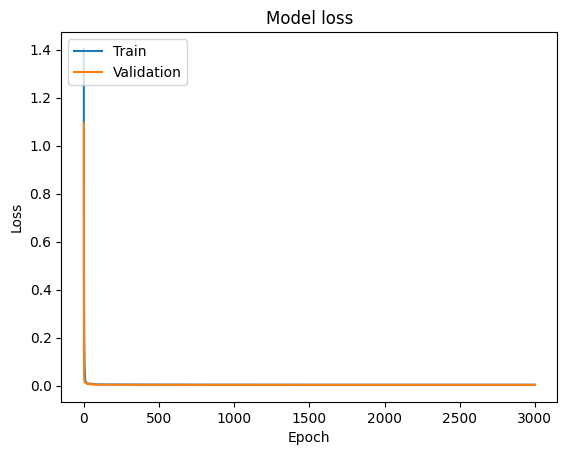

In [34]:
dp = 0.3 # set Dropout rate 
nu = 700 # number of neurons in each layer 
ne = 3000 # number of epochs

#################################### Model Architecture #############################################
model = Sequential()

model.add(Dense(nu, activation='relu', input_dim=x_train.shape[1], kernel_initializer='he_normal')) # Hidden 1
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 2
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 3
model.add(BatchNormalization())
model.add(Dropout(dp))

model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 4
model.add(BatchNormalization())
model.add(Dropout(dp))

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 5
# model.add(BatchNormalization())
# model.add(Dropout(dp))

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 6

# model.add(Dense(nu, activation='relu', kernel_initializer='he_normal')) # Hidden 7



model.add(Dense(y_train.shape[1], activation='linear',kernel_initializer='he_normal')) # Output

################################## Model Configuration #####################################



# model.add(Dense(y.shape[1])) # Output
# model.compile(loss='mean_absolute_error', metrics = ['mae'], optimizer='adam')
# reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.2,patience=10, min_lr=0.0001)
# filepath="weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=1, save_best_only=True)



loss_fn = losses.MeanSquaredError() # set loss function 
Adam(learning_rate=0.09456, beta_1=0.9, beta_2=0.999, amsgrad=False) # set configuration of Optimizer
model.compile(loss=loss_fn, optimizer='adam', metrics=['MSE'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=10, min_lr=0.0001)
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath,save_weights_only=True, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(x_train,y_train,verbose=1,epochs=ne , validation_data = (x_val,y_val),batch_size=100,callbacks=[checkpoint,reduce_lr])

# plot training history
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


### 13. Evaluate the model!

In [35]:
# Evaluation
start_SE = time()
pred = model.predict(x_test)
end_SE = time()
elapsed_time = end_SE - start_SE

# convert normalized data back to actual values before calculating MAE and MAPE
pred_actual = np.zeros(y_test.shape)
for j in range(main_y_train.shape[1]):
    t2,y_min,y_max = normalize(main_y_train[:,j])
    pred_actual[:,j] = (pred[:,j]*(y_max-y_min))+y_min
    
# even_index = np.arange(0,y_test.shape[1],2)
# odd_index = np.arange(1,y_test.shape[1],2)

num_buses = df_V_mag.shape[1]
pred_mag_actual = pred_actual[:,0:num_buses] #first 2000 columns are related to mag
pred_ang_actual = pred_actual[:,-num_buses:]  #last 2000 columns are related to ang

phase_MAE = mean_absolute_error(pred_actual[:,-num_buses:], main_y_test[:,-num_buses:])
#Formulate MAPE by my own
mag_MAPE = np.sum(abs((main_y_test[:,0:num_buses]-pred_actual[:,0:num_buses])/main_y_test[:,0:num_buses]))/main_y_test[:,0:num_buses].shape[0]/(main_y_test[:,0:num_buses].shape[1])*100
#MAPE using the function (both give the same results)
mag_MAPE2 = mean_absolute_percentage_error(pred_actual[:,0:num_buses], main_y_test[:,0:num_buses])

print('MSE based on normalized data:')
print(f' MSE_mag: {loss_fn(pred_actual[:,0:num_buses], main_y_test[:,0:num_buses])}')
print(f' MSE_ang: {loss_fn(pred_actual[:,-num_buses:], main_y_test[:,-num_buses:])}')

print('MAE and MAPE Losses Based on Actual Data')
print(f'MAE_ang: {phase_MAE:.5f}, MAPE_mag: {mag_MAPE:.7f}')


125/125 [==============================] - 3s 25ms/step


C:\Users\smoshta1\AppData\Local\Temp\4\ipykernel_21692\3989276298.py:7: RuntimeWarning: invalid value encountered in divide
  x_norm = (x-x_min)/(x_max-x_min)


MSE based on normalized data:
 MSE_mag: 9.562077059305427e-06
 MSE_ang: 0.024854052463530073
MAE and MAPE Losses Based on Actual Data
MAE_ang: 0.10354, MAPE_mag: 0.1844535


#### Calculate MAE and MAPE for each bus separately to plot the results

In [36]:
# Calculate MAPE for each bus separately (Mag)
mag_MAPE_sep = np.sum(abs((main_y_test[:,0:num_buses]-pred_mag_actual[:,0:num_buses])/main_y_test[:,0:num_buses]), axis=0)/main_y_test[:,0:num_buses].shape[0]*100

In [37]:
# Calculate MAE for each bus separately (Ang)
ang_MAE_sep = np.sum(abs((main_y_test[:,-num_buses:]-pred_ang_actual[:,-num_buses:])), axis=0)/main_y_test[:,-num_buses:].shape[0]

### Store errors to compare them with LSE results

In [33]:
# GAUSSIAN NOISE
np.savetxt('DNN-SE_MAPE_mag.csv', mag_MAPE_sep , delimiter=',')
np.savetxt('DNN-SE_MAE_ang.csv', ang_MAE_sep , delimiter=',')

### Plot the results

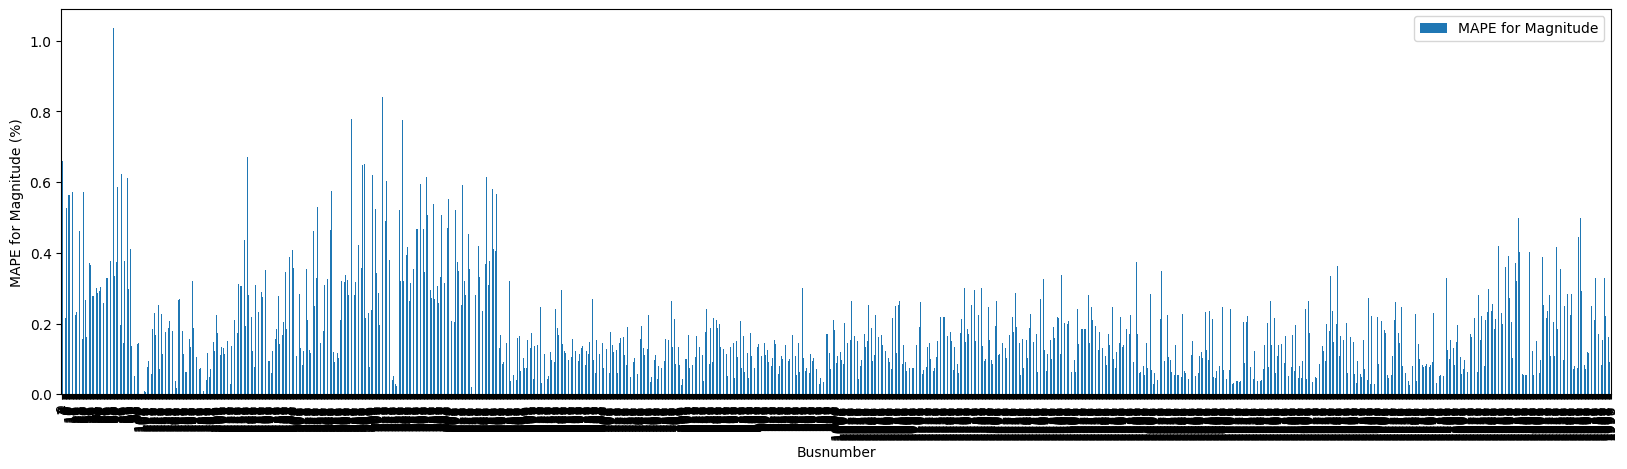

In [38]:
mag_error = mag_MAPE_sep
df = pd.DataFrame({'MAPE for Magnitude':mag_error }, index=range(0,num_buses))

df.plot(kind='bar',figsize=(20,5), xlabel=('Busnumber'), ylabel=('MAPE for Magnitude (%)'))

plt.show()

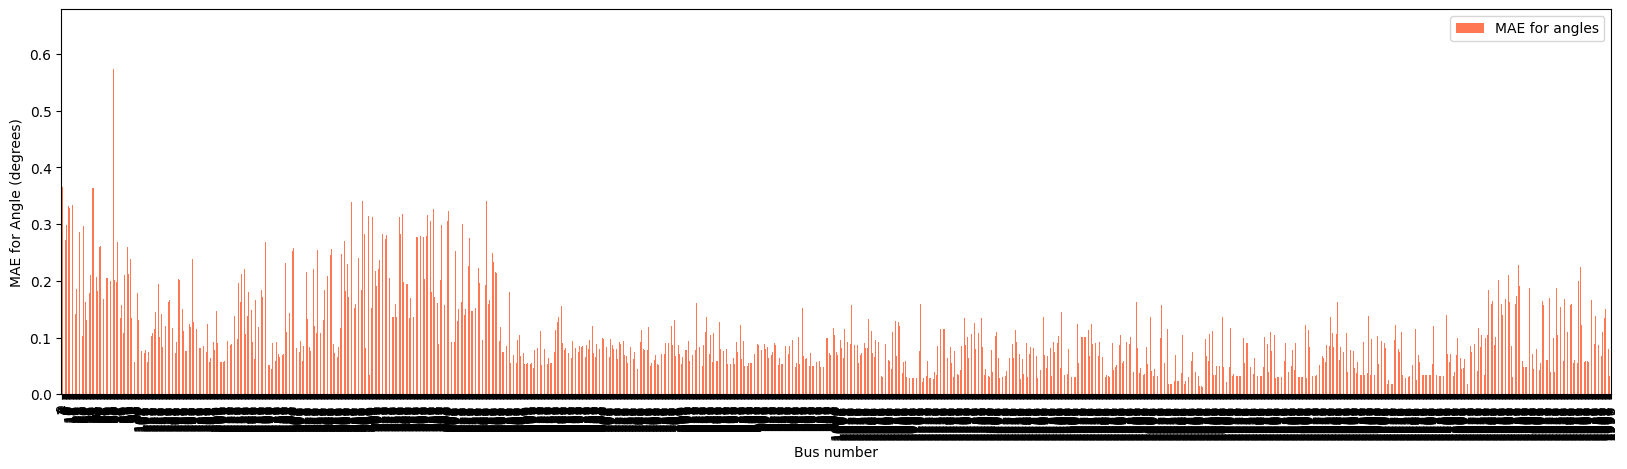

In [39]:
ang_error = ang_MAE_sep
df = pd.DataFrame({'MAE for angles': ang_error })

df.plot(kind='bar',figsize=(20,5), color='#FF7753', xlabel=('Bus number'), ylabel=('MAE for Angle (degrees)'))

plt.show()